In [14]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

ImportError: cannot import name 'builder_impl' from 'tensorflow.python.saved_model' (/Users/michielkoch/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/saved_model/__init__.py)

In [2]:
# hyperparameters

step = 60 
batch_size = 16
#optimizer = optimizers.Adam(lr = 0.001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "C:/Users/086096/thesis_files/"
segment_length = 960
learning_rate = 0.0001

MADRS_LABLES = ['control', 'depression', 'ADHD']
MADRS_VALUES = [0, 7, 20]
classes = len(MADRS_VALUES)

In [3]:
def create_segments_and_labels_2(dataset_dir, segment_length, step, leave_out_id=None):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores8.csv'))
    scores['waarde'].fillna(0, inplace=True)
    
    segments = []
    labels = []

    left_out_segments = []
    left_out_correct = None

    if leave_out_id == None:
        leave_out_id = random.randint(0, len(scores['number']))

    for i, person in enumerate(scores['number']):
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        p_label = None

        for j in range(classes):
            if p['waarde'].values[0] >= MADRS_VALUES[classes - j - 1]:
                p_label = classes - j - 1
                break

        assert p_label != None, f'Could not get target label: {p}'

        # For the participant that we are leaving out
        if i == leave_out_id:
            left_out_correct = p_label

        for j in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['Magnitude.mean'].values[j : j + segment_length]
            
            #For the participant that we are leaving out
            if i == leave_out_id:
                left_out_segments.append([segment])
            else:
                segments.append([segment])
                labels.append(p_label)

    #assert left_out_correct != None and len(left_out_segments) > 0, f'Did not set data for left out participant {leave_out_id}'
    
    labels = np.asarray(labels).astype('float32')
    labels = to_categorical(labels, 3)
    
    segments = np.asarray(segments).reshape(-1, segment_length, 1)
    #left_out_segments = np.asarray(left_out_segments).reshape(-1, segment_length, 1)

    num_time_periods, num_sensors = segments.shape[1], segments.shape[2]
    input_shape = num_time_periods * num_sensors

    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    #left_out_segments = left_out_segments.reshape(left_out_segments.shape[0], input_shape).astype('float32')
    
    return segments, labels, input_shape



In [16]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
print(create_segments_and_labels_2(data_dir,segment_length,step))

(array([[0.043232, 0.08168 , 0.01811 , ..., 0.062163, 0.011337, 0.010288],
       [0.128714, 0.101046, 0.331317, ..., 0.055553, 0.031634, 0.05851 ],
       [0.006379, 0.007886, 0.01208 , ..., 0.016275, 0.085776, 0.035873],
       ...,
       [0.032906, 0.015272, 0.040999, ..., 0.033849, 0.032655, 0.033597],
       [0.152917, 0.136762, 0.040138, ..., 0.032351, 0.032457, 0.035026],
       [0.048456, 0.025114, 0.01568 , ..., 0.033075, 0.032111, 0.032617]],
      dtype=float32), array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32), 960)


In [5]:
segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)
print(segments.shape)
print(labels.shape)
print(np.isnan(labels).any())
print(np.isnan(segments).any())

(6224, 960)
(6224, 3)
False
False


In [6]:
labels2 = np.argmax(labels,axis=1)
print(labels2)
print(np.unique(labels2))
print(labels2.shape)

[2 2 2 ... 0 0 0]
[0 1 2]
(6224,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

In [8]:
print(X_train)
print(X_train.shape)
print()
print(X_test)
print(X_test.shape)
print()
print(y_train)
print(y_train.shape)
print()
print(y_test)
print(y_test.shape)

[[0.010057 0.015808 0.022355 ... 0.013893 0.010699 0.012192]
 [0.006625 0.013068 0.006351 ... 0.007963 0.017613 0.023788]
 [0.038292 0.038883 0.039494 ... 0.044429 0.056047 0.065069]
 ...
 [0.03966  0.02078  0.075532 ... 0.10058  0.053131 0.030787]
 [0.031318 0.060406 0.085444 ... 0.034431 0.025011 0.054038]
 [0.040074 0.028402 0.045674 ... 0.19326  0.153761 0.156597]]
(4979, 960)

[[0.015819 0.008723 0.021669 ... 0.16285  0.111293 0.052209]
 [0.015695 0.008432 0.014164 ... 0.014217 0.023466 0.009162]
 [0.174709 0.079621 0.103258 ... 0.107843 0.082819 0.084679]
 ...
 [0.024623 0.057679 0.020899 ... 0.009341 0.021188 0.031939]
 [0.131944 0.12039  0.142705 ... 0.038544 0.033063 0.067358]
 [0.11484  0.082749 0.137364 ... 0.043279 0.047751 0.050296]]
(1245, 960)

[1 0 1 ... 0 2 1]
(4979,)

[2 1 2 ... 1 1 2]
(1245,)


16hours - 960 timesteps

In [9]:
svclassifier = SVC(kernel = "rbf")
svclassifier.fit(X_train,y_train)

SVC()

In [10]:
y_pred = svclassifier.predict(X_test)

In [11]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[125  89 158]
 [ 87 160 164]
 [ 65  71 326]]
              precision    recall  f1-score   support

           0       0.45      0.34      0.39       372
           1       0.50      0.39      0.44       411
           2       0.50      0.71      0.59       462

    accuracy                           0.49      1245
   macro avg       0.48      0.48      0.47      1245
weighted avg       0.49      0.49      0.48      1245



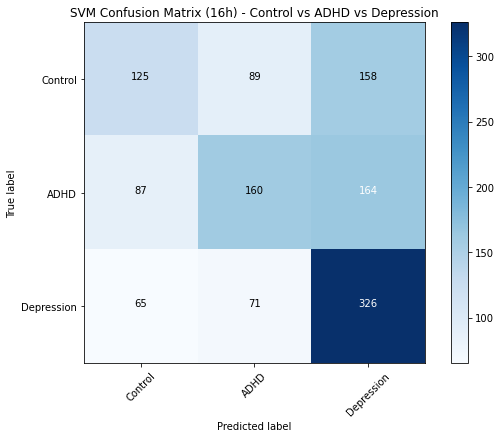

In [17]:
plot_confusion_matrix(cm           = np.array([[ 125,  89,   158],
                                              [  87,  160,  164],
                                              [  65,  71, 326]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "SVM Confusion Matrix (16h) - Control vs ADHD vs Depression")

24hours - 1440 timesteps

In [12]:
segment_length = 1440

segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)

labels2 = np.argmax(labels,axis=1)

X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

print(X_train)
print(X_train.shape)
print()
print(X_test)
print(X_test.shape)
print()
print(y_train)
print(y_train.shape)
print()
print(y_test)
print(y_test.shape)

[[0.053722 0.017967 0.026631 ... 0.011803 0.015162 0.014835]
 [0.014875 0.009124 0.015429 ... 0.039954 0.038809 0.051594]
 [0.027237 0.052006 0.083712 ... 0.014306 0.010164 0.011041]
 ...
 [0.020846 0.02444  0.060075 ... 0.021411 0.068916 0.044473]
 [0.032747 0.015891 0.048478 ... 0.071344 0.103821 0.024098]
 [0.25587  0.234859 0.07548  ... 0.048808 0.043661 0.041536]]
(4583, 1440)

[[0.042653 0.027119 0.025604 ... 0.009812 0.022183 0.013542]
 [0.010748 0.074919 0.019651 ... 0.044686 0.006451 0.006796]
 [0.02192  0.011091 0.050917 ... 0.010253 0.042141 0.068705]
 ...
 [0.02371  0.106903 0.028903 ... 0.046022 0.214814 0.133827]
 [0.070228 0.021009 0.071529 ... 0.162153 0.210902 0.166509]
 [0.03969  0.111627 0.128819 ... 0.013949 0.013472 0.010209]]
(1146, 1440)

[2 1 0 ... 0 1 1]
(4583,)

[0 2 0 ... 2 1 0]
(1146,)


In [13]:
svclassifier = SVC(kernel = "rbf")
svclassifier.fit(X_train,y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[119  97 152]
 [ 62 194 135]
 [ 63  70 254]]
              precision    recall  f1-score   support

           0       0.49      0.32      0.39       368
           1       0.54      0.50      0.52       391
           2       0.47      0.66      0.55       387

    accuracy                           0.49      1146
   macro avg       0.50      0.49      0.48      1146
weighted avg       0.50      0.49      0.49      1146



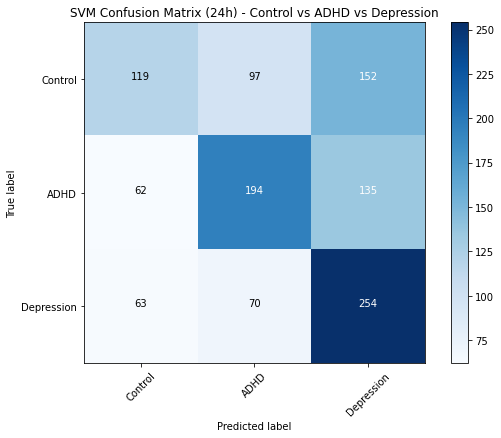

In [22]:
plot_confusion_matrix(cm           = np.array([[ 119,  97,   152],
                                              [  62,  194,  135],
                                              [  63,  70, 254]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "SVM Confusion Matrix (24h) - Control vs ADHD vs Depression")

48hours - 2880 timesteps

In [14]:
segment_length = 2880

segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)

labels2 = np.argmax(labels,axis=1)

X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

print(X_train)
print(X_train.shape)
print()
print(X_test)
print(X_test.shape)
print()
print(y_train)
print(y_train.shape)
print()
print(y_test)
print(y_test.shape)

[[0.018079 0.056282 0.017142 ... 0.023489 0.121992 0.065636]
 [0.100813 0.030757 0.119253 ... 0.01369  0.011616 0.006261]
 [0.01308  0.019016 0.059873 ... 0.055004 0.042896 0.051037]
 ...
 [0.057095 0.038026 0.034732 ... 0.046872 0.076321 0.029698]
 [0.060705 0.01765  0.050383 ... 0.00494  0.005689 0.008226]
 [0.023784 0.011793 0.026762 ... 0.051317 0.016791 0.067018]]
(3544, 2880)

[[0.019552 0.008301 0.015333 ... 0.006568 0.005088 0.005579]
 [0.020305 0.043349 0.028454 ... 0.009663 0.041039 0.057167]
 [0.043804 0.053528 0.063009 ... 0.195688 0.080184 0.094942]
 ...
 [0.081686 0.057265 0.043015 ... 0.309486 0.021485 0.012337]
 [0.020315 0.016542 0.036963 ... 0.043903 0.031487 0.022405]
 [0.042652 0.070367 0.032472 ... 0.011879 0.013243 0.011399]]
(886, 2880)

[2 0 2 ... 2 1 1]
(3544,)

[1 0 2 0 1 1 0 0 2 0 1 0 2 1 1 1 2 2 2 2 2 0 1 2 2 1 0 2 0 2 0 2 2 0 1 1 1
 2 0 1 1 2 2 1 0 1 2 1 1 2 1 0 1 1 0 2 1 0 2 2 2 2 1 2 0 1 1 2 2 2 0 0 1 2
 0 2 0 0 2 2 2 0 1 0 1 1 0 1 1 0 1 2 2 1 1 2 1 2 1 2

In [15]:
svclassifier = SVC(kernel = "rbf")
svclassifier.fit(X_train,y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 93  76  90]
 [ 48 144 104]
 [ 34  43 254]]
              precision    recall  f1-score   support

           0       0.53      0.36      0.43       259
           1       0.55      0.49      0.52       296
           2       0.57      0.77      0.65       331

    accuracy                           0.55       886
   macro avg       0.55      0.54      0.53       886
weighted avg       0.55      0.55      0.54       886



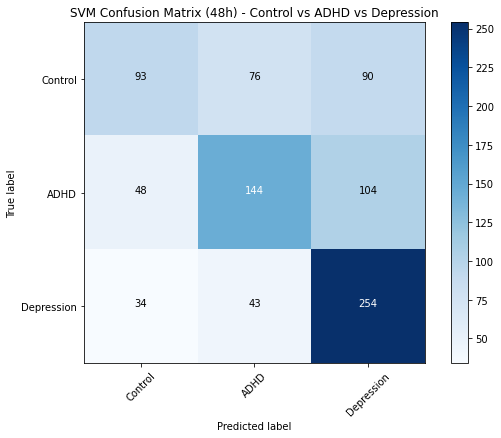

In [19]:
plot_confusion_matrix(cm           = np.array([[ 93,  76,   90],
                                              [  48,  144,  104],
                                              [  34,  43, 254]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "SVM Confusion Matrix (48h) - Control vs ADHD vs Depression")

72hours - 4320 timesteps

In [16]:
segment_length = 4320

segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)

labels2 = np.argmax(labels,axis=1)

X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

#print(X_train)
print(X_train.shape)
print()
#print(X_test)
print(X_test.shape)
print()
#print(y_train)
print(y_train.shape)
print()
#print(y_test)
print(y_test.shape)

(2369, 4320)

(593, 4320)

(2369,)

(593,)


In [17]:
svclassifier = SVC(kernel = "rbf")
svclassifier.fit(X_train,y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 64  58  64]
 [ 28 101  60]
 [ 33  39 146]]
              precision    recall  f1-score   support

           0       0.51      0.34      0.41       186
           1       0.51      0.53      0.52       189
           2       0.54      0.67      0.60       218

    accuracy                           0.52       593
   macro avg       0.52      0.52      0.51       593
weighted avg       0.52      0.52      0.52       593



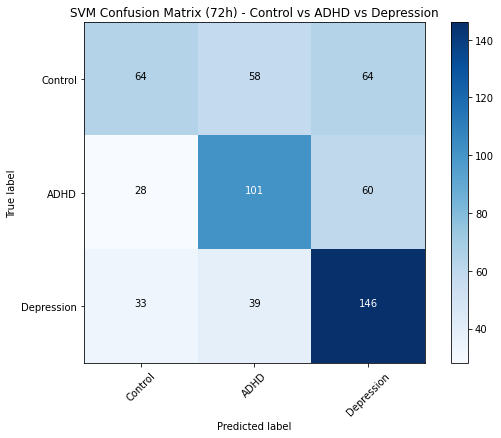

In [20]:
plot_confusion_matrix(cm           = np.array([[ 64,  58,   64],
                                              [  28,  101,  60],
                                              [  33,  39, 146]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "SVM Confusion Matrix (72h) - Control vs ADHD vs Depression")

96hours - 5760 timesteps

In [18]:
segment_length = 5760

segments, labels, input_shape = create_segments_and_labels_2(data_dir, segment_length, step)

labels2 = np.argmax(labels,axis=1)

X_train, X_test, y_train, y_test = train_test_split(segments, labels2, test_size=0.2, random_state=17)

#print(X_train)
print(X_train.shape)
print()
#print(X_test)
print(X_test.shape)
print()
#print(y_train)
print(y_train.shape)
print()
#print(y_test)
print(y_test.shape)

(1394, 5760)

(349, 5760)

(1394,)

(349,)


In [19]:
svclassifier = SVC(kernel = "rbf")
svclassifier.fit(X_train,y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 23  28  33]
 [ 11  54  53]
 [ 12  11 124]]
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        84
           1       0.58      0.46      0.51       118
           2       0.59      0.84      0.69       147

    accuracy                           0.58       349
   macro avg       0.56      0.52      0.52       349
weighted avg       0.57      0.58      0.55       349



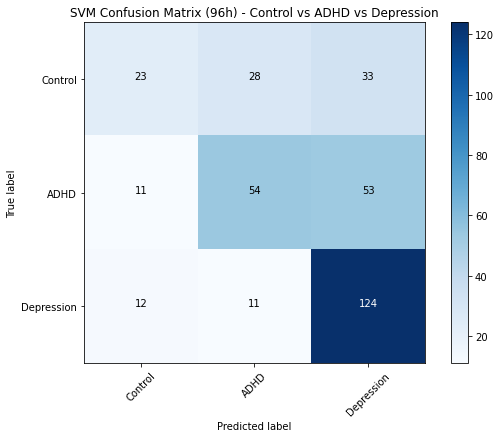

In [24]:
plot_confusion_matrix(cm           = np.array([[ 23,  28,   33],
                                              [  11,  54,  53],
                                              [  12,  11, 124]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "SVM Confusion Matrix (96h) - Control vs ADHD vs Depression")




In [ ]:
hkjbkj

16h

[[125  89 158]
 [ 87 160 164]
 [ 65  71 326]]
              precision    recall  f1-score   support

           0       0.45      0.34      0.39       372
           1       0.50      0.39      0.44       411
           2       0.50      0.71      0.59       462

    accuracy                           0.49      1245
   macro avg       0.48      0.48      0.47      1245
weighted avg       0.49      0.49      0.48      1245

24h

[[119  97 152]
 [ 62 194 135]
 [ 63  70 254]]
              precision    recall  f1-score   support

           0       0.49      0.32      0.39       368
           1       0.54      0.50      0.52       391
           2       0.47      0.66      0.55       387

    accuracy                           0.49      1146
   macro avg       0.50      0.49      0.48      1146
weighted avg       0.50      0.49      0.49      1146

48h

[[ 93  76  90]
 [ 48 144 104]
 [ 34  43 254]]
              precision    recall  f1-score   support

           0       0.53      0.36      0.43       259
           1       0.55      0.49      0.52       296
           2       0.57      0.77      0.65       331

    accuracy                           0.55       886
   macro avg       0.55      0.54      0.53       886
weighted avg       0.55      0.55      0.54       886

72h

[[ 64  58  64]
 [ 28 101  60]
 [ 33  39 146]]
              precision    recall  f1-score   support

           0       0.51      0.34      0.41       186
           1       0.51      0.53      0.52       189
           2       0.54      0.67      0.60       218

    accuracy                           0.52       593
   macro avg       0.52      0.52      0.51       593
weighted avg       0.52      0.52      0.52       593

96h

[[ 23  28  33]
 [ 11  54  53]
 [ 12  11 124]]
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        84
           1       0.58      0.46      0.51       118
           2       0.59      0.84      0.69       147

    accuracy                           0.58       349
   macro avg       0.56      0.52      0.52       349
weighted avg       0.57      0.58      0.55       349

In [1]:
import numpy as np

In [12]:
np.mean([35,51,69])

51.666666666666664

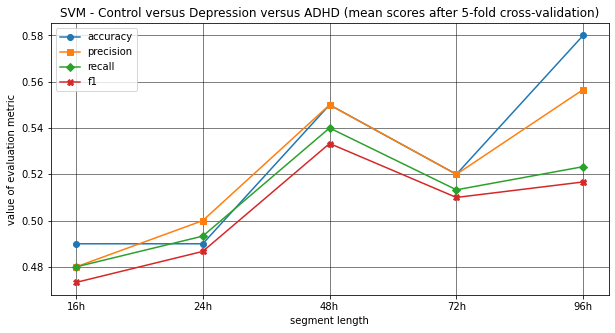

In [15]:
acc = [0.49,0.49,0.55,0.52,0.58]
prec = [0.48,0.50,0.55,0.52,0.5566]
reca = [0.48,0.4933,0.54,0.5133,0.5233]
f1 = [0.4733,0.4867,0.5333,0.51,0.5167]
acc_perc = np.multiply(acc, 1)
prec_perc = np.multiply(prec, 1)
reca_perc = np.multiply(reca, 1)
f1_perc = np.multiply(f1, 1)

plt.figure(figsize=(10, 5))
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.plot(acc_perc, marker = 'o')
plt.plot(prec_perc, marker = 's')
plt.plot(reca_perc, marker = 'D')
plt.plot(f1_perc, marker = 'X')
plt.xticks(np.arange(5),['16h','24h','48h','72h','96h'])
plt.legend(['accuracy','precision','recall','f1'])
plt.title("SVM - Control versus Depression versus ADHD (mean scores after 5-fold cross-validation)")
plt.xlabel('segment length')
plt.ylabel('value of evaluation metric')
plt.show()

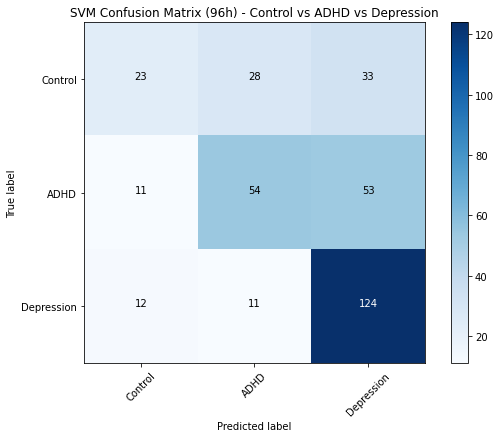

In [25]:
plot_confusion_matrix(cm           = np.array([[ 23,  28,   33],
                                              [  11,  54,  53],
                                              [  12,  11, 124]]), 
                      normalize    = False,
                      target_names = ['Control','ADHD', 'Depression'],
                      title        = "SVM Confusion Matrix (96h) - Control vs ADHD vs Depression")